In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import sys 
sys.path.append('../../src')
import glob
from spaceoracle.prophets import Prophet

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8779 × 3512
    obs: 'batch', 'rxn', 'n_counts', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'medulla_cortex', 'domain', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'cell_type_int'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [6]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from velocyto.estimation import colDeltaCor, colDeltaCorpartial

def estimate_transition_probabilities(adata, delta_X, embedding=None, n_neighbors=200, 
random_neighbors=False, annot=None, T=0.05, n_jobs=1):

    n_cells, n_genes = adata.shape
    delta_X = np.array(delta_X)
    gene_mtx = adata.layers['imputed_count']
    
    if n_neighbors is None:

        P = np.ones((n_cells, n_cells))

        corr = colDeltaCor(
            np.ascontiguousarray(gene_mtx.T), 
            np.ascontiguousarray(delta_X.T), 
            threads=n_jobs
            )
    
    else:

        P = np.zeros((n_cells, n_cells))

        n_neighbors = min(n_cells, n_neighbors)
        
        if random_neighbors == 'even':

            cts = np.unique(adata.obs[annot])
            ct_dict = {ct: np.where(adata.obs[annot] == ct)[0] for ct in cts}
            cells_per_ct = round(n_neighbors / len(cts))

            indices = []

            for i in range(n_cells):
                i_indices = []

                for ct, ct_cells in ct_dict.items():

                    sample = np.random.choice(ct_cells[ct_cells != i], size=cells_per_ct, replace=False)
                    i_indices.extend(sample)

                i_indices = np.array(i_indices)
                P[i, i_indices] = 1
                indices.append(i_indices)

            indices = np.array(indices)

        elif random_neighbors:
            
            indices = []
            cells = np.arange(n_cells)
            for i in range(n_cells):
                i_indices = np.random.choice(np.delete(cells, i), size=n_neighbors, replace=False)
                P[i, i_indices] = 1
                indices.append(i_indices)
            
            indices = np.array(indices)

        else: 

            nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=n_jobs)
            nn.fit(embedding)
            _, indices = nn.kneighbors(embedding)

            rows = np.repeat(np.arange(n_cells), n_neighbors)
            cols = indices.flatten()
            P[rows, cols] = 1

        corr = colDeltaCorpartial(
            np.ascontiguousarray(gene_mtx.T), 
            np.ascontiguousarray(delta_X.T), 
            indices, threads=n_jobs
            )

    np.fill_diagonal(P, 0)
    
    corr = np.nan_to_num(corr, nan=1)

    P *= np.exp(corr / T)   
    P /= P.sum(1)[:, None]

    return P

In [7]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=50)
sc.tl.umap(adata)

In [11]:
import cellrank as cr

In [14]:
dfx = adata.to_df(layer='imputed_count')

In [15]:
dfx['Cryab'] = 0

In [16]:
emb = estimate_transition_probabilities(
    adata, 
    adata.to_df(layer='imputed_count').values-dfx.values, 
    # np.random.permutation(adata.to_df(layer='imputed_count').values),
    n_neighbors=None,
    embedding=None, 
    n_jobs=8)

In [17]:
adata.obsp['ko_shift'] = emb
ck = cr.kernels.ConnectivityKernel(adata, conn_key='ko_shift')
# ck = cr.kernels.ConnectivityKernel(adata, conn_key='connectivities')
ck.compute_transition_matrix(density_normalize=True)

ConnectivityKernel[n=8779, dnorm=True, key='ko_shift']

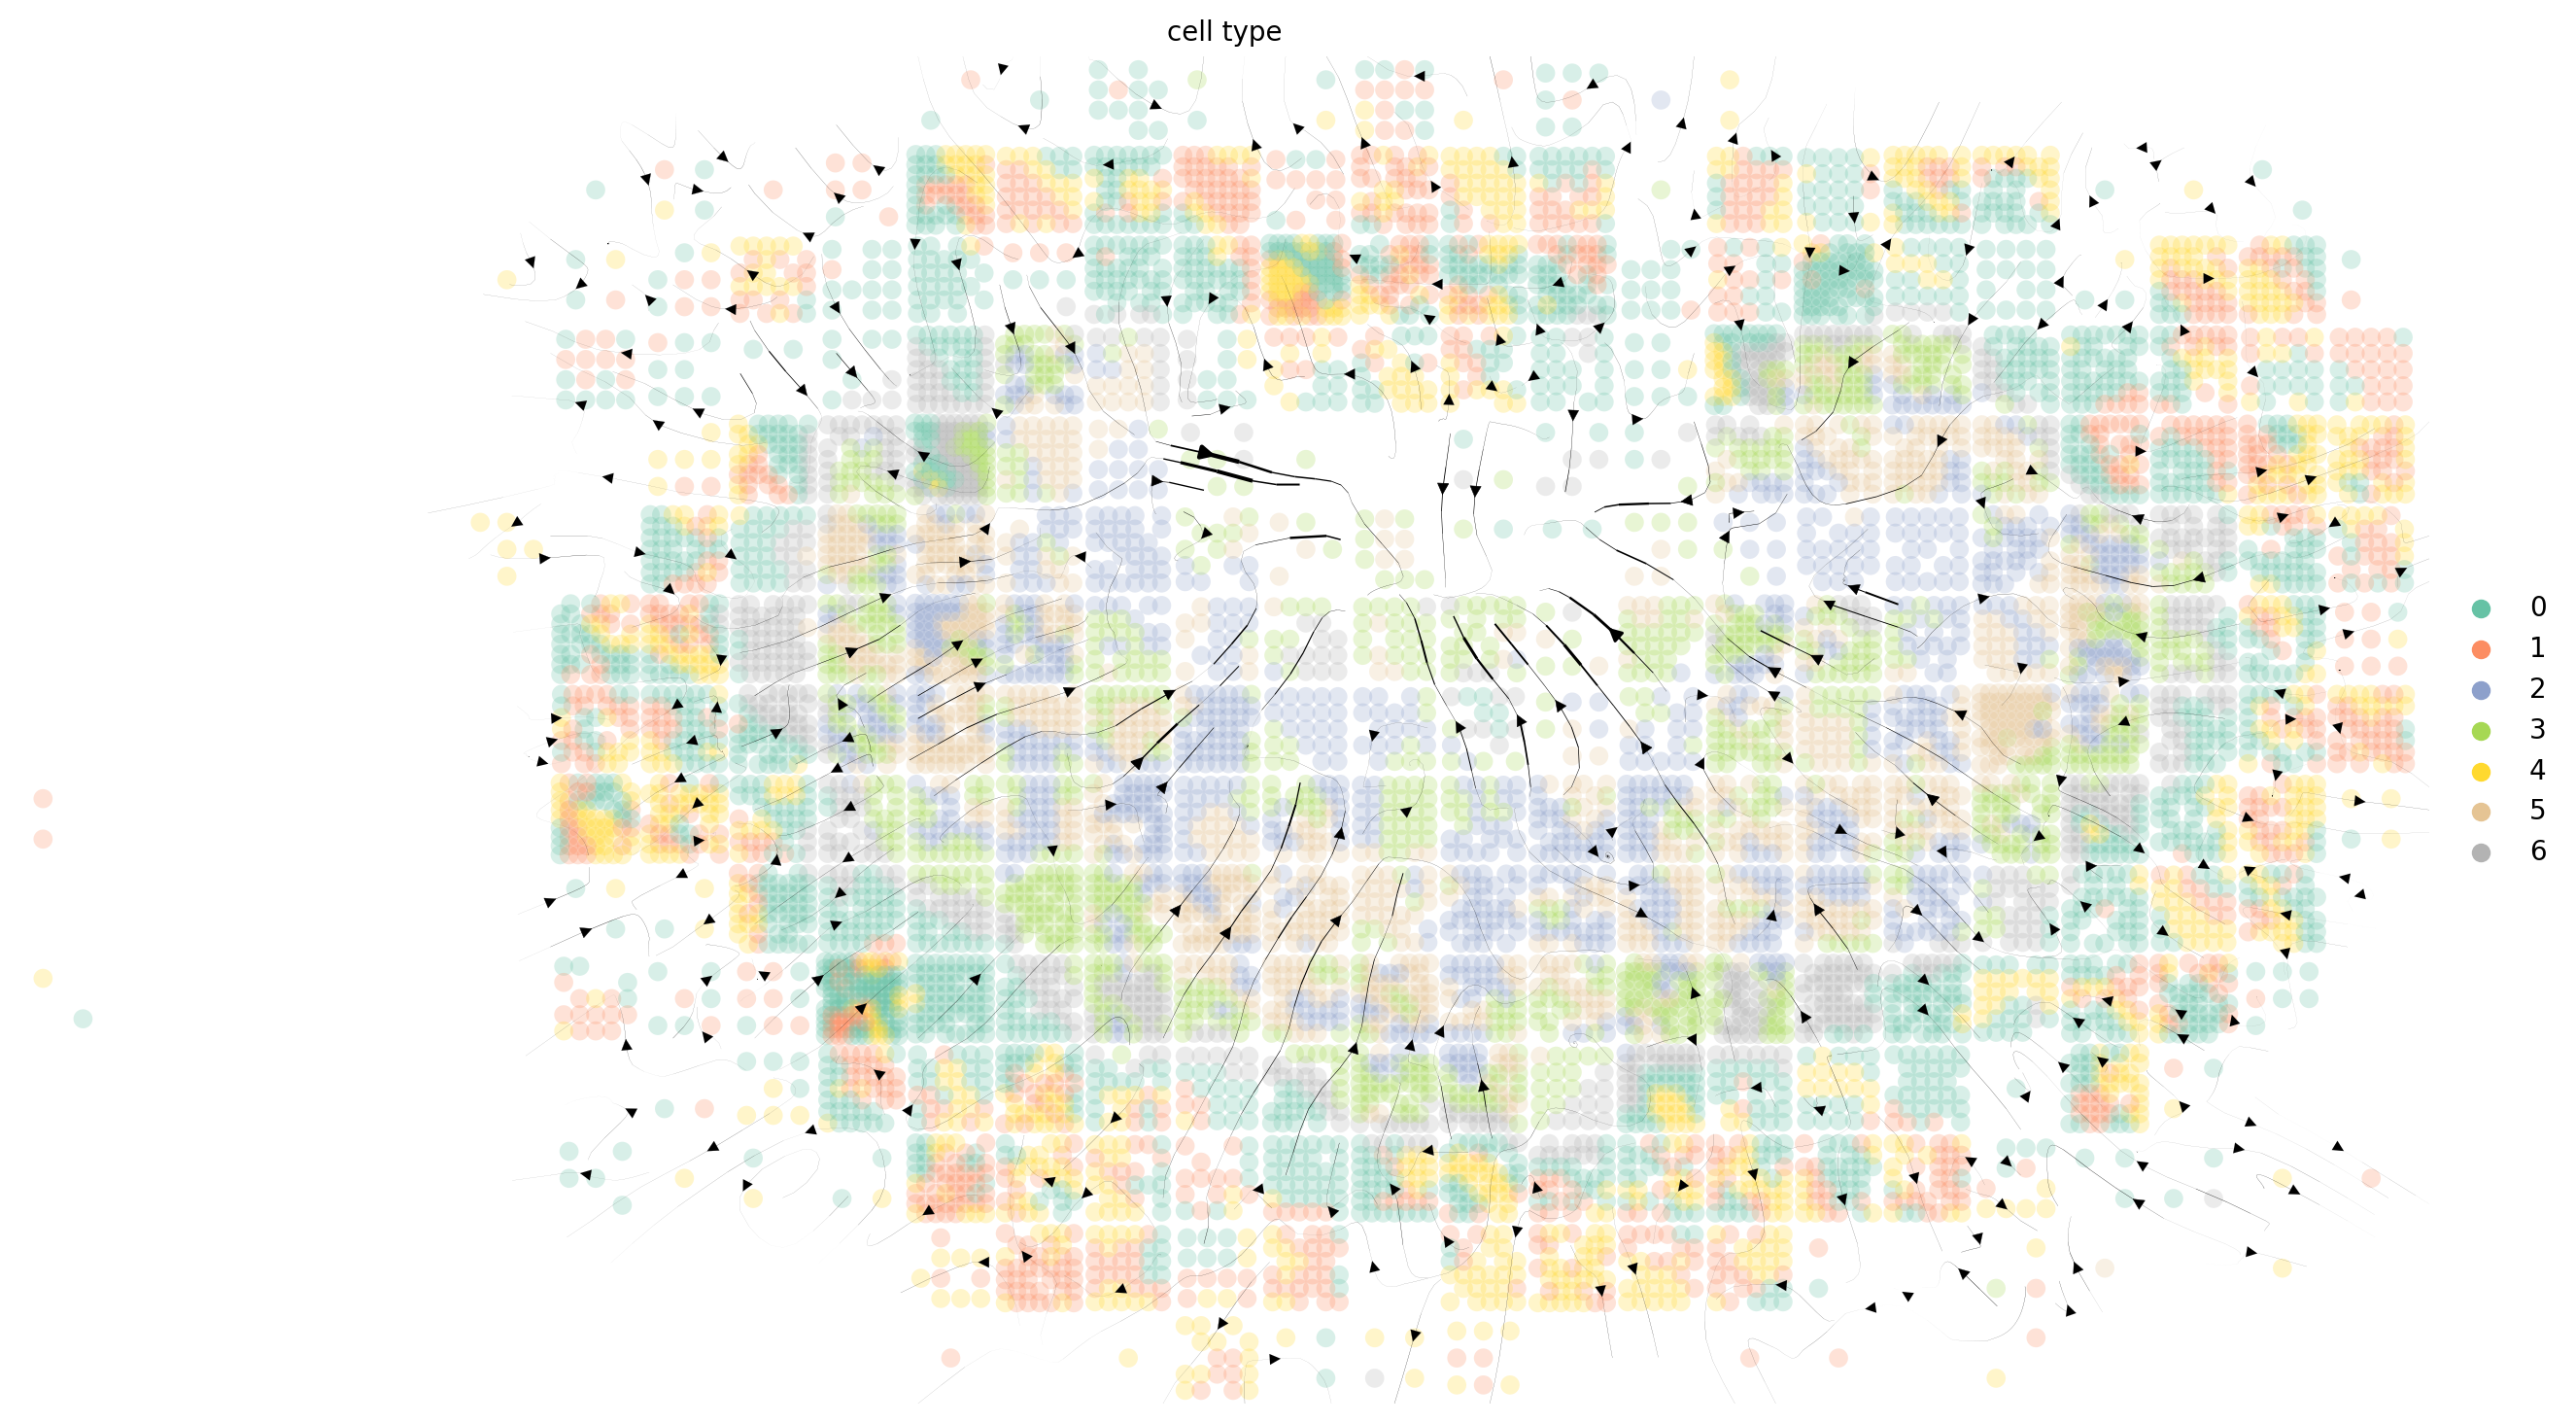

In [20]:
plt.rcParams['figure.figsize'] = (16, 9)
ck.plot_projection(
    basis='spatial', color='cell_type', 
    palette='Set2',
    stream=True, 
    legend_loc='right', 
    recompute=True,
    # scale=0.7,
    alpha=0.25,
    size=200,
    show=False
)